In [100]:
import os, sys, requests, zipfile
import geopandas as gpd
import pandas as pd
sys.path.append('..')
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
%autoreload 2
from onstove import OnStove, DataProcessor, RasterLayer, VectorLayer
# from onstove.raster import interpolate
import time

In [102]:
output_directory = "KEN"

In [103]:
results = OnStove.read_model(f"{output_directory}/results.pkl")

In [104]:
#In the beginning of the code just add start values 0 for future shares
for item in iter(results.techs):
    results.techs[item].future_share_urban = 0
    results.techs[item].future_share_rural = 0 

In [107]:
#User defined in the tech specs, only for testing purposes here. 
#Code below now can take into account any fuel combinations in urban and rural settlements
results.techs["LPG"].future_share_rural = 0.2
results.techs["Electricity"].future_share_rural = 0.2
results.techs['Biomass Forced Draft'].future_share_rural = 0.2
results.techs["Charcoal ICS"].future_share_rural = 0.4

results.techs["LPG"].future_share_urban = 0.4
results.techs["Electricity"].future_share_urban = 0.5
results.techs["Charcoal ICS"].future_share_urban = 0.1

In [108]:
from copy import deepcopy
results_copy = deepcopy(results)

In [109]:
import pandas as pd
import pulp
import numpy as np

def prioritization(data, urban):

    tech = []
    share = []
    # in the final code I want people to be able to use parameters named future_share_urban and future_share_rural and this helps us distinguish between rural and urban
    gdf = data.reset_index()
    if urban:
        mask = gdf['IsUrban'] > 20 
        for item in iter(results.techs):
            if results.techs[item].future_share_urban > 0:
                share.append(results.techs[item].future_share_urban)
                tech.append(item)
                if item not in results.gdf.columns:
                    results.gdf[item] = 0.0
    else:
        mask = gdf['IsUrban'] < 20
        for item in iter(results.techs):
            if results.techs[item].future_share_rural > 0:
                share.append(results.techs[item].future_share_rural)
                tech.append(item)
                if item not in results.gdf.columns:
                    results.gdf[item] = 0.0
    
    res = gdf[mask].copy() 
    res1 = res.set_index('index')

    # Parameters
    populations = res1['Calibrated_pop'].to_numpy()    
    tech_dict = {t: (res1['net_benefit_'+t] * res1['Households']).fillna(0).to_numpy() for t in tech} 
    total_population = populations.sum()
    n = len(res1)

    # Set up the Problem
    prob = pulp.LpProblem("MaximizeNetBenefit", pulp.LpMaximize)

    # Define decision variables, using Continuous, because the other option is too slow
    x = pulp.LpVariable.dicts("x", [(i, j) for i in range(n) for j in range(len(tech))], lowBound=0, upBound=1, cat="Continuous")

    matrix = np.stack(list(tech_dict.values()), axis=1)
    
    prob += pulp.lpSum(matrix[i, j] * x[i, j] for i in range(n) for j in range(len(tech))), "TotalMaxNetBenefit"

    # Each row has only one tech
    for i in range(n):
        prob += pulp.lpSum(x[i, j] for j in range(len(tech))) == 1, f"RowSelection_{i}"

    # Population proporortions
    for idx, percentage in enumerate(share):
        prob += pulp.lpSum(populations[i] * x[i, idx] for i in range(n)) == percentage * total_population, f"Population{chr(65 + idx)}"

    # Solve using the CBC solver, can not make HiGHS work... I think it would be faster. Perhaps also try commercial solvers just for fun
    prob.solve(pulp.PULP_CBC_CMD(msg=0))

    print("Status:", pulp.LpStatus[prob.status])

    selected = np.array([[x[i, j].varValue for j in range(len(tech))] for i in range(n)])

    selected_params = {tech[i]: selected[:, i] for i in range(len(tech))}

    for tech_name, values in selected_params.items():
        results.gdf.loc[mask, tech_name] = values


In [110]:
prioritization(results.gdf, True)

Status: Optimal


In [111]:
prioritization(results.gdf, False)

Status: Optimal


In [112]:
def prio(row):
    priorities = []
    filtered_techs = {key: value for key, value in results["techs"].items() if ((hasattr(value, "future_share_urban") and getattr(value, "future_share_urban") > 0) or (hasattr(value, "future_share_rural") and getattr(value, "future_share_rural") > 0))}
    for item in iter(filtered_techs):
        if row[item] > 0:
            priorities.append(item)
    return ' and '.join(priorities)

In [113]:
results.gdf['Prioritized_hh'] = results.gdf.apply(prio, axis=1)

In [114]:
cmap = {"Biomass ICS (ND)": '#6F4070', "LPG": '#66C5CC', "Biomass": '#FFB6C1',
        "Biomass ICS (FD)": '#af04b3', "Pellets ICS (FD)": '#ef02f5',
        "Charcoal": '#364135', "Charcoal ICS": '#d4bdc5',
        "Charcoal ICS and Charcoal ICS": '#d4bdc5',
        "AND":"Purple",
        "Biogas": '#73AF48', "Biogas and Biomass ICS (ND)": "#F6029E",
        "Biogas and Biomass ICS (FD)": "#F6029E",
        "Biogas and Pellets ICS (FD)": "#F6029E",
        "Biogas and LPG": "#0F8554", "Biogas and Biomass": "#266AA6",
        "Biogas and Charcoal": "#3B05DF",
        "LPG and Charcoal ICS": "magenta",
        "Biogas and Charcoal ICS": "#3B59DF",
        "Electricity": '#CC503E', "Electricity and Biomass ICS (ND)": "#B497E7",
        "Electricity and Biomass ICS (FD)": "#B497E7",
        "Electricity and Pellets ICS (FD)": "#B497E7",
        "Electricity and LPG": "#E17C05", "Electricity and Biomass": "#FFC107",
        "Electricity and Charcoal ICS": "#660000",
        "Electricity and Biogas": "#f97b72",
        'Biogas and Biogas': "#f97b72",
        '':"Gray",
        "Charcoal ICS and Biomass ICS (FD)": 'Black',
        "None": "Grey",
        "Electricity and Charcoal": "#FF0000"}


# This becomes super messy as the code is already done so you have stuff like 'Electricity and Charcoal ICS and Electricity and Charcoal ICS'
labels = {"Biogas and Electricity": "Electricity and Biogas",
          "Biogas and Bioags": "Biogas",
          "LPG and LPG":"LPG",
          "Electricity and Electricity and Charcoal ICS":'Electricity and Charcoal ICS',
          'Charcoal ICS and Electricity and Charcoal ICS':'Electricity and Charcoal ICS',
          'Electricity and Charcoal ICS and Electricity':'Electricity and Charcoal ICS',
          'Electricity and Charcoal ICS and Electricity and Charcoal ICS':'Electricity and Charcoal ICS',
          'Electricity and Charcoal ICS and Charcoal ICS':'Electricity and Charcoal ICS',
          "Charcoal ICS and Charcoal ICS":"Charcoal ICS",
          'LPG and Charcoal ICS and LPG and Charcoal ICS':"LPG and Charcoal ICS",
          'LPG and Electricity':"Electricity and LPG",
          'LPG and Electricity and LPG':"Electricity and LPG",
          'Electricity and Electricity and LPG':'Electricity and LPG',
          'LPG and Biogas': "Biogas and LPG",
          'Charcoal ICS and Biogas': "Biogas and Charcoal ICS",
          'Charcoal ICS and Electricity': "Electricity and Charcoal ICS",
          "Electricity and Electricity": "Electricity",
          'Collected Traditional Biomass': 'Biomass',
          'Collected Improved Biomass': 'Biomass ICS (ND)',
          'LPG and LPG and Charcoal ICS': "LPG and Charcoal ICS",
          'LPG and Charcoal ICS and Charcoal ICS':'LPG and Charcoal ICS',
          'LPG and Charcoal ICS and LPG': "LPG and Charcoal ICS",
          'Charcoal ICS and LPG and Charcoal ICS': "LPG and Charcoal ICS",
          'Traditional Charcoal': 'Charcoal',
          'Charcoal ICS and LPG and Charcoal ICS and LPG':'LPG and Charcoal ICS',
          'Electricity and LPG and Electricity':'Electricity and LPG',
          'Electricity and LPG and LPG':'Electricity and LPG',
          'Electricity and LPG and Electricity and LPG':'Electricity and LPG',
          'Charcoal ICS and LPG':'LPG and Charcoal ICS',
          ' and ': "",
          'Biomass and Biomass':'Biomass',
          'Charcoal ICS and Biomass ICS (FD) and Charcoal ICS':'Charcoal ICS and Biomass ICS (FD)',
          'Biomass Forced Draft and Charcoal ICS':'Charcoal ICS and Biomass ICS (FD)',
          'Biomass Forced Draft and Charcoal ICS and Biomass Forced Draft and Charcoal ICS': 'Charcoal ICS and Biomass ICS (FD)',
          'Biomass ICS (FD) and Biomass ICS (FD)': 'Biomass ICS (FD)',
          'Biomass Forced Draft and Charcoal ICS and Charcoal ICS':'Charcoal ICS and Biomass ICS (FD)',
          'Biomass Forced Draft': 'Biomass ICS (FD)',
          'Biomass ICS (FD) and Charcoal ICS':'Charcoal ICS and Biomass ICS (FD)',
          'Charcoal ICS and Biomass ICS (FD) and Biomass ICS (FD)':'Charcoal ICS and Biomass ICS (FD)',
          'Biomass ICS (FD) and Charcoal ICS and Biomass ICS (FD)':'Charcoal ICS and Biomass ICS (FD)',
          'Charcoal ICS and Charcoal ICS and Biomass ICS (FD)':'Charcoal ICS and Biomass ICS (FD)',
          'Charcoal ICS and Biomass ICS (FD) and Charcoal ICS and Biomass ICS (FD)': 'Charcoal ICS and Biomass ICS (FD)',
          'Biomass ICS (FD) and Biomass Forced Draft and Charcoal ICS':'Charcoal ICS and Biomass ICS (FD)',
          'Biomass Forced Draft and Charcoal ICS and Biomass ICS (FD)':'Charcoal ICS and Biomass ICS (FD)',
          'Charcoal ICS and Biomass Forced Draft and Charcoal ICS':'Charcoal ICS and Biomass ICS (FD)',
          'Charcoal ICS and Biomass Forced Draft':'Charcoal ICS and Biomass ICS (FD)',
          'Pellets Forced Draft': 'Pellets ICS (FD)'}

<Axes: >

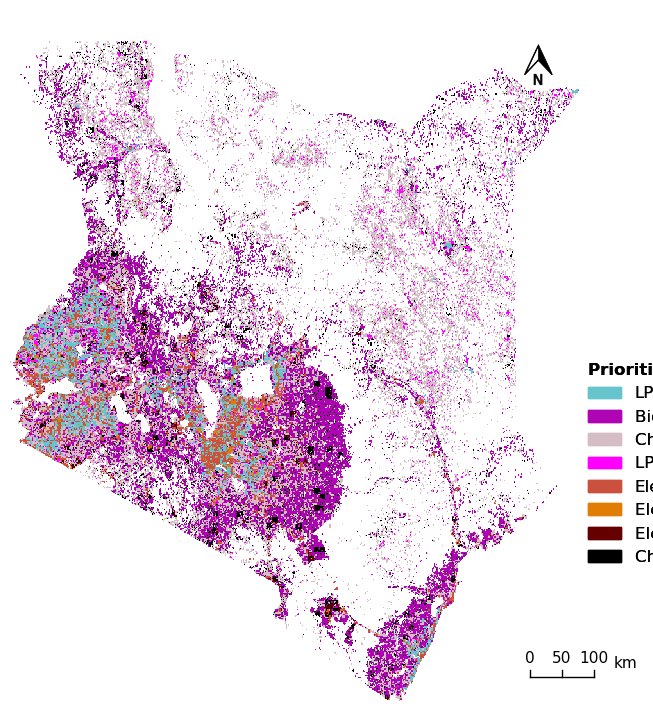

In [115]:
scale_bar_prop = dict(size=100000, style='double', textprops=dict(size=11), location=(1, 0.02),
                      linekw=dict(lw=1, color='black'), extent=0.01, loc='lower center')
north_arrow_prop = dict(size=30, location=(0.92, 0.92), linewidth=0.5)


#Stats not updated so probably wrong.
results.plot('Prioritized_hh', cmap=cmap,
                   labels=labels,
                   legend_position=(1, 0.5), 
                   figsize=(13, 9),  
                   legend_title='Prioritized areas',
                   stats=False, 
                   scale_bar=scale_bar_prop, north_arrow=north_arrow_prop, save_as='map.pdf')